# Human Action Recognition

Models create a sequence to sequence ("seq2seq") system to identify the human activities for Kinetics-400 dataset.
The models use the Video Transformer approach with ResNet34 encoder
### Video Transformer
The Video Transformer model is composed of two main components: the spatial transformer and the temporal transformer. The spatial transformer is responsible for processing the spatial information of each frame in the video, while the temporal transformer is responsible for processing the temporal information between frames. These two components work together to provide a comprehensive understanding of the video data.

The spatial transformer consists of a convolutional neural network (CNN) that is used to extract features from each frame. The extracted features are then fed into the self-attention mechanism of the transformer architecture. The self-attention mechanism is used to weigh the importance of each feature and produce a more representative feature vector for each frame.

The temporal transformer is similar to the spatial transformer, except that it takes into account the relationships between frames. The temporal transformer uses the same self-attention mechanism as the spatial transformer, but it also includes a temporal attention mechanism that is used to weigh the importance of each frame in the video. This allows the model to focus on the most important frames in the video and ignore redundant or irrelevant frames.

The Video Transformer model can be trained on large datasets of videos and their corresponding labels. During the training process, the model learns to recognize the patterns and relationships in the video data and make predictions based on this information. The trained model can then be used to make predictions on new, unseen video data.

https://theaisummer.com/transformers-computer-vision/

![image.png](videot.png)

#### Video Vision Transformer
https://arxiv.org/abs/2103.15691

### ModelZoo

https://docs.openvino.ai/archive/2020.2/usergroup13.html


### Install

pip install -q "openvino>=2024.0.0" "opencv-python" "tqdm"

### Kinetics 400
The dataset contains 400 human action classes, with at least 400 video clips for each action. Each clip lasts around 10s and is taken from a different YouTube video. The actions are human focussed and cover a broad range of classes including human-object interactions such as playing instruments, as well as human-human interactions such as shaking hands.

- https://paperswithcode.com/dataset/kinetics-400-1
- https://github.com/cvdfoundation/kinetics-dataset


In [1]:
import collections
import os
import time
from typing import Tuple, List

from pathlib import Path

import cv2
import numpy as np
from IPython import display
import openvino as ov
from openvino.runtime.ie_api import CompiledModel

# Fetch `notebook_utils` module
import requests

# r = requests.get(
#     url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/notebook_utils.py",
# )
# open("notebook_utils.py", "w").write(r.text)
import notebook_utils as utils

# action-recognition-0001
This is a general-purpose action recognition model for Kinetics-400 dataset. The model uses Video Transformer approach with ResNet34 encoder.

- encoder : accepts video frame and produces embedding
- decoder : produce prediction from embeddings of 16 frames

In [47]:
# A directory where the model will be downloaded.
base_model_dir = "model"
# The name of the model from Open Model Zoo.
model_name = "action-recognition-0001"
# Selected precision (FP32, FP16, FP16-INT8).
precision = "FP16"
model_path_decoder = f"model/intel/{model_name}/{model_name}-decoder/{precision}/{model_name}-decoder.xml"
model_path_encoder = f"model/intel/{model_name}/{model_name}-encoder/{precision}/{model_name}-encoder.xml"
encoder_url = f"https://storage.openvinotoolkit.org/repositories/open_model_zoo/temp/{model_name}/{model_name}-encoder/{precision}/{model_name}-encoder.xml"
decoder_url = f"https://storage.openvinotoolkit.org/repositories/open_model_zoo/temp/{model_name}/{model_name}-decoder/{precision}/{model_name}-decoder.xml"

if not os.path.exists(model_path_decoder):
    utils.download_ir_model(decoder_url, Path(model_path_decoder).parent)
if not os.path.exists(model_path_encoder):
    utils.download_ir_model(encoder_url, Path(model_path_encoder).parent)

# Kinetics-400 dataset 
The dataset contains 400 human action classes, with at least 400 video clips for each action. Each clip lasts around 10s and is taken from a different YouTube video. The actions are human focussed and cover a broad range of classes including human-object interactions such as playing instruments, as well as human-human interactions such as shaking hands.

https://paperswithcode.com/dataset/kinetics-400-1

In [48]:
# Download the text from the openvino_notebooks storage
vocab_file_path = utils.download_file(
    "https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/text/kinetics.txt",
    directory="data",
)

with vocab_file_path.open(mode="r") as f:
    labels = [line.strip() for line in f]

print(labels[0:9], np.shape(labels))

'data/kinetics.txt' already exists.
['abseiling', 'air drumming', 'answering questions', 'applauding', 'applying cream', 'archery', 'arm wrestling', 'arranging flowers', 'assembling computer'] (400,)


In [49]:
import ipywidgets as widgets

#Core class represents OpenVINO runtime Core entity.
core = ov.Core()
device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value="AUTO",
    description="Device:",
    disabled=False,
)

device

Dropdown(description='Device:', index=1, options=('CPU', 'AUTO'), value='AUTO')

In [50]:
# Initialize OpenVINO Runtime.
core = ov.Core()


def model_init(model_path: str, device: str) -> Tuple:
    """
    Read the network and weights from a file, load the
    model on CPU and get input and output names of nodes

    :param:
            model: model architecture path *.xml
            device: inference device
    :retuns:
            compiled_model: Compiled model
            input_key: Input node for model
            output_key: Output node for model
    """

    # Read the network and corresponding weights from a file.
    model = core.read_model(model=model_path)
    # Compile the model for specified device.
    compiled_model = core.compile_model(model=model, device_name=device)
    # Get input and output names of nodes.
    input_keys = compiled_model.input(0)
    output_keys = compiled_model.output(0)
    return input_keys, output_keys, compiled_model

In [51]:
# Encoder initialization
input_key_en, output_keys_en, compiled_model_en = model_init(model_path_encoder, device.value)
# Decoder initialization
input_key_de, output_keys_de, compiled_model_de = model_init(model_path_decoder, device.value)

# Get input size - Encoder.
height_en, width_en = list(input_key_en.shape)[2:]
# Get input size - Decoder.
frames2decode = list(input_key_de.shape)[0:][1]

In [52]:
input_key_en, output_keys_en, input_key_de, output_keys_de

(<ConstOutput: names[0] shape[1,3,224,224] type: f32>,
 <ConstOutput: names[371] shape[1,512,1,1] type: f32>,
 <ConstOutput: names[0] shape[1,16,512] type: f32>,
 <ConstOutput: names[674] shape[1,400] type: f32>)

In [53]:
from helpers import  center_crop, adaptive_resize, decode_output, rec_frame_display, display_text_fnc
from ai_functions import preprocessing, encoder, decoder, softmax


In [61]:
def run_action_recognition(
    source: str = "0",
    flip: bool = True,
    labels:List[str]=[],
    use_popup: bool = False,
    compiled_model_en: CompiledModel = compiled_model_en,
    compiled_model_de: CompiledModel = compiled_model_de,
    skip_first_frames: int = 0,

):
    """
    Use the "source" webcam or video file to run the complete pipeline for action-recognition problem
    1. Create a video player to play with target fps
    2. Prepare a set of frames to be encoded-decoded
    3. Preprocess frame before Encoder
    4. Encoder Inference per frame
    5. Decoder inference per set of frames
    6. Visualize the results

    :param: source: webcam "0" or video path
    :param: flip: to be used by VideoPlayer function for flipping capture image
    :param: use_popup: False for showing encoded frames over this notebook, True for creating a popup window.
    :param: skip_first_frames: Number of frames to skip at the beginning of the video.
    :returns: display video over the notebook or in a popup window

    """
    size = height_en  # Endoder input size - From Cell 5_9
    sample_duration = frames2decode  # Decoder input size - From Cell 5_7
    # Select frames per second of your source.
    fps = 30
    player = None
    try:
        # Create a video player.
        player = utils.VideoPlayer(source, flip=flip, fps=fps, skip_first_frames=skip_first_frames)
        # Start capturing.
        player.start()
        if use_popup:
            title = "Press ESC to Exit"
            cv2.namedWindow(title, cv2.WINDOW_GUI_NORMAL | cv2.WINDOW_AUTOSIZE)

        processing_times = collections.deque()
        processing_time = 0
        encoder_output = []
        decoded_labels = [0, 0, 0]
        decoded_top_probs = [0, 0, 0]
        counter = 0
        # Create a text template to show inference results over video.
        text_inference_template = "Infer Time:{Time:.1f}ms,{fps:.1f}FPS"
        text_template = "{label},{conf:.2f}%"

        while True:
            counter = counter + 1

            # Read a frame from the video stream.
            frame = player.next()
            if frame is None:
                print("Source ended")
                break

            scale = 1280 / max(frame.shape)

            # Adaptative resize for visualization.
            if scale < 1:
                frame = cv2.resize(frame, None, fx=scale, fy=scale, interpolation=cv2.INTER_AREA)

            # Select one frame every two for processing through the encoder.
            # After 16 frames are processed, the decoder will find the action,
            # and the label will be printed over the frames.

            if counter % 2 == 0:
                # Preprocess frame before Encoder.
                (preprocessed, _) = preprocessing(frame, size)

                # Measure processing time.
                start_time = time.time()

                # Encoder Inference per frame
                encoder_output.append(encoder(preprocessed, compiled_model_en))

                # Decoder inference per set of frames
                # Wait for sample duration to work with decoder model.
                if len(encoder_output) == sample_duration:
                    decoded_labels, decoded_top_probs = decoder(encoder_output, labels,compiled_model_de)
                    encoder_output = []

                # Inference has finished. Display the results.
                stop_time = time.time()

                # Calculate processing time.
                processing_times.append(stop_time - start_time)

                # Use processing times from last 200 frames.
                if len(processing_times) > 200:
                    processing_times.popleft()

                # Mean processing time [ms]
                processing_time = np.mean(processing_times) * 1000
                fps = 1000 / processing_time

            # Visualize the results.
            for i in range(0, 3):
                display_text = text_template.format(
                    label=decoded_labels[i],
                    conf=decoded_top_probs[i] * 100,
                )
                display_text_fnc(frame, display_text, i)

            display_text = text_inference_template.format(Time=processing_time, fps=fps)
            display_text_fnc(frame, display_text, 3)

            # Use this workaround if you experience flickering.
            if use_popup:
                cv2.imshow(title, frame)
                key = cv2.waitKey(1)
                # escape = 27
                if key == 27:
                    break
            else:
                # Encode numpy array to jpg.
                _, encoded_img = cv2.imencode(".jpg", frame, params=[cv2.IMWRITE_JPEG_QUALITY, 90])
                # Create an IPython image.
                i = display.Image(data=encoded_img)
                # Display the image in this notebook.
                display.clear_output(wait=True)
                display.display(i)

    # ctrl-c
    except KeyboardInterrupt:
        print("Interrupted")
    # Any different error
    except RuntimeError as e:
        print(e)
    finally:
        if player is not None:
            # Stop capturing.
            player.stop()
        if use_popup:
            cv2.destroyAllWindows()

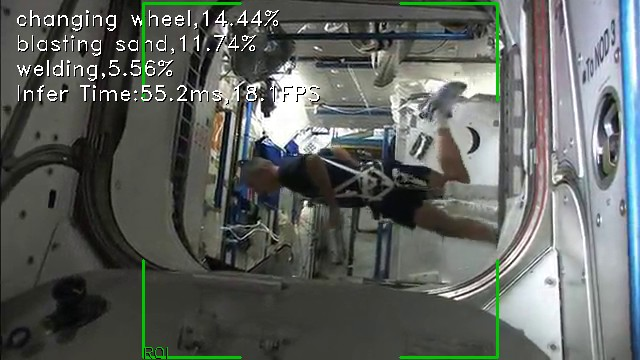

Source ended


In [55]:
USE_WEBCAM = False

cam_id = 0
video_file = "https://archive.org/serve/ISSVideoResourceLifeOnStation720p/ISS%20Video%20Resource_LifeOnStation_720p.mp4"

source = cam_id if USE_WEBCAM else video_file
additional_options = {"skip_first_frames": 600, "flip": False} if not USE_WEBCAM else {"flip": True}
run_action_recognition(source=source, use_popup=False, labels=labels,**additional_options)

# Model name: driver-action-recognition-adas-0002
This is an action recognition model for the driver monitoring use case. The model uses Video Transformer approach with MobileNetv2 encoder. It is able to recognize the following actions: drinking, doing hair or making up, operating the radio, reaching behind, safe driving, talking on the phone, texting.

- encoder : accepts video frame and produces embedding
- decoder : produce prediction from embeddings of 16 frames

In [56]:
# A directory where the model will be downloaded.
base_model_dir = "model"
# The name of the model from Open Model Zoo.
model_name = "driver-action-recognition-adas-0002"
# Selected precision (FP32, FP16, FP16-INT8).
precision = "FP16"
model_path_decoder = f"model/intel/{model_name}/{model_name}-decoder/{precision}/{model_name}-decoder.xml"
model_path_encoder = f"model/intel/{model_name}/{model_name}-encoder/{precision}/{model_name}-encoder.xml"
encoder_url = f"https://storage.openvinotoolkit.org/repositories/open_model_zoo/temp/{model_name}/{model_name}-encoder/{precision}/{model_name}-encoder.xml"
decoder_url = f"https://storage.openvinotoolkit.org/repositories/open_model_zoo/temp/{model_name}/{model_name}-decoder/{precision}/{model_name}-decoder.xml"

if not os.path.exists(model_path_decoder):
    utils.download_ir_model(decoder_url, Path(model_path_decoder).parent)
if not os.path.exists(model_path_encoder):
    utils.download_ir_model(encoder_url, Path(model_path_encoder).parent)

In [57]:
# Download the text from the openvino_notebooks storage
vocab_file_path = utils.download_file(
    "https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/text/driver_actions.txt",
    directory="data",
)

with vocab_file_path.open(mode="r") as f:
    labels = [line.strip() for line in f]

print(labels[0:9], np.shape(labels))

'data/driver_actions.txt' already exists.
['Safe driving', 'Texting left', 'Texting right', 'Talking phone left', 'Talking phone right', 'Operating radio', 'Drinking eating', 'Reaching behind', 'Hair and makeup'] (9,)


In [58]:
import ipywidgets as widgets

core = ov.Core()
device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value="AUTO",
    description="Device:",
    disabled=False,
)

device

Dropdown(description='Device:', index=1, options=('CPU', 'AUTO'), value='AUTO')

In [59]:
# Encoder initialization
input_key_en, output_keys_en, compiled_model_en = model_init(model_path_encoder, device.value)
# Decoder initialization
input_key_de, output_keys_de, compiled_model_de = model_init(model_path_decoder, device.value)

# Get input size - Encoder.
height_en, width_en = list(input_key_en.shape)[2:]
# Get input size - Decoder.
frames2decode = list(input_key_de.shape)[0:][1]

In [60]:
from helpers import  center_crop, adaptive_resize, decode_output, rec_frame_display, display_text_fnc
from ai_functions import preprocessing, encoder, decoder, softmax

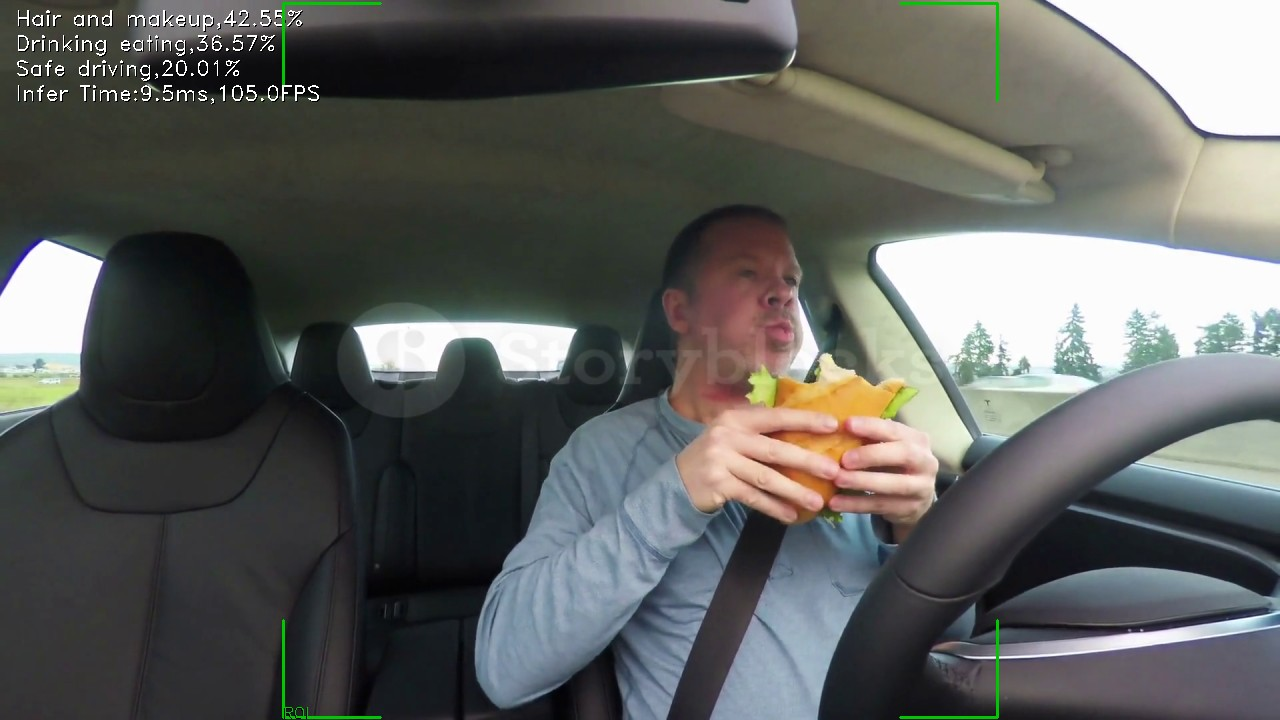

Source ended


In [62]:
USE_WEBCAM = False

cam_id = 0
video_file = "file:///mnt/d/repos/openvino/HAR/data/man-eating-lunch-while-driving-his-car-with-no-hands-SBV-305303247-preview.mp4"

source = cam_id if USE_WEBCAM else video_file
additional_options = {"skip_first_frames": 600, "flip": False} if not USE_WEBCAM else {"flip": True}
run_action_recognition(source=source, use_popup=False, labels=labels,**additional_options)